# Prototype Data Reduction Pipeline


M31 Region J-K Reduction

# SETUP

### Import Statements

In [1]:
# Python Imports
import numpy as np
import matplotlib.pyplot as pl
import subprocess
import netCDF4

# Line Data Reduction Imports
# Line Data Reduction Imports
from lmtslr.spec.spec import *
from lmtslr.ifproc.ifproc import *
from lmtslr.viewer.spec_viewer import *

from lmtslr.reduction.line_reduction import *
from lmtslr.grid.grid import *

# set up the grid geometry
theGrid = Grid()

# Pipeline S/W Imports
#from lmtslr.cube_reader import *

### Set up parameters

The pipeline requires a number of parameters to be set in order to complete its task.  These are all set up in the following code cell.

The specific parameters are:

* Raw Spectral Line Data Reduction Parameters
    * `data_path` - path to the data files
    * `obsnum`  - ObsNum of the observation to process
    * `bank`    - select the *bank* of the spectral line (always 0 for SEQUOIA at this point)
    * `tsys`    - a value to use for the system temperature if you choose *NOT* to use the calibration scan data.
    * `list_of_pixels` - a python list of the pixel id numbers to be processed
    * `use_calibration` - a boolean to select whether to use the cal scan (True) or just multiply by a constant.
    * `baseline_order` - order of the polynomial to be removed from each spectrum.
    * `line_integral_list` - a python list of lists to provide regions for integration over line in analysis.
    * `baseline_list` - a python list of lists to indicate the regions where the baseline will be fit.
    * `slice_list` - a python list to provide limits of spectrum to be prepared for the SpecFile.
* SpecFile Preparation Parameters
    * `netcdf_filename` - name of the SpecFile, to be written in NetCDF format
    * `rms_cut` - threshhold for excluding individual spectra when viewing the spectra in display example for the SpecFile
* OTF Gridding Process Parameters
    * `ProgramPath` - full path name for the C program that does the gridding
    * `FitsFileName` - file name for the output FITS file
    * `xextent` - dimension of the data cube along the "x" spatial axis
    * `yextent` - dimension of the data cube along the "y" spatial axis
    * `rmscutoff` - threshold for exclusion of spectra from gridding process
* Parameters for the Cube Reader display examples
    * `Cmax` - maximum value in 2D map display example
    * `xb`, `xe` - pixel limits on x axis in 2D map display example
    * `yb`, `ye` - pixel limits on y axis in 2D map display example
    * `v_val` - pixel number on spectral axis for 2D display example
    * `x_val` - pixel number on x axis for 2D display example
    * `y_val` - pixel number on y axis for 2D display example


In [2]:
data_path = '/Volumes/FPS/data_lmt/'  
obsnum = 85778
bank=0          # SEQUOIA data for always in bank 0
tsys = 220.     # tsys to use in case use_calibration is False
list_of_pixels = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15]  # pixels to process for map

use_calibration = False

baseline_order = 0
line_integral_list = [[-320,-220]]  
baseline_list = [[-620,-320],[-220,80]]
# we are only going to write channels in this velocity range
slice_list = [-620,80]

# here is the name of the netcdf file for output
# please note that if the file exists, it will be overwritten!
netcdf_filename = './M31_Region_J-K.nc'

#ViewSpecFile Parameters
rms_cut = 10

# C Program Parameters
ProgramPath='./spec_driver_fits'
FitsFileName = './M31_Region_J-K.fits'
xextent = '250'
yextent = '250'
rmscutoff = '1.3'


# Cube_Reader Parameters
Cmax = 1
v_val=330
x_val=30
y_val=47
xb,xe=0,72
yb,ye=0,72

# check to see whether files exist, and remove if they do
if os.path.isfile(netcdf_filename) == True: 
    os.remove(netcdf_filename) 
if os.path.isfile(FitsFileName) == True: 
    os.remove(FitsFileName) 


# READ AND PROCESS THE DATA FILES

With all parameters defined, we can make the first step of processing the Roach and IFProc data files. The processing function used here is located in *line_reduction.py*.

The function `read_obsnum_otf` reads and reduces all the spectra in the observaiton file.  Currently it is hard coded to reduce these using an average spectrum computed from all the reference observations in the map.  The function can be modified to do one of the other options for reference removal if needed.



In [3]:
# read the data from the relevant files for this obsnum
# note use of "data_path" to set the path to the data.  Default path is '/data_lmt/'
I,S = read_obsnum_otf(obsnum,list_of_pixels,bank,use_calibration,tsys=tsys,path=data_path)

found roach0_85778_0_1_Region_J-K_2019-10-31_073122.nc
append roach0_85778_0_1_Region_J-K_2019-10-31_073122.nc
found roach1_85778_0_1_Region_J-K_2019-10-31_073122.nc
append roach1_85778_0_1_Region_J-K_2019-10-31_073122.nc
found roach2_85778_0_1_Region_J-K_2019-10-31_073122.nc
append roach2_85778_0_1_Region_J-K_2019-10-31_073122.nc
found roach3_85778_0_1_Region_J-K_2019-10-31_073122.nc
append roach3_85778_0_1_Region_J-K_2019-10-31_073122.nc
found ifproc_2019-10-31_085778_00_0001.nc
before read npix
from pixels npix = 16
from xlen npix = 16
TRACKING Sequoia PIXEL  10
Map Parameters: Ra Continuous
HPBW= 12.0 XLength=   300.0 YLength=   300.0 XStep=  1.25 YStep=  0.40
/Volumes/FPS/data_lmt/ifproc/ifproc_2019-10-31_085778_00_0001.nc does not have bs parameters
85778 is a Map observation
read_roach /Volumes/FPS/data_lmt/spectrometer/roach0/roach0_85778_0_1_Region_J-K_2019-10-31_073122.nc
r:0 inp:0 pix:0 to:-0.030000
r:0 inp:1 pix:1 to:-0.030000
r:0 inp:2 pix:2 to:-0.030000
r:0 inp:3 pix:3 to

### Example of Line Processing

Here we provide a short example of line analysis of the reduced data.  A particular spectrum from the OTF data (located near the source position) is selected.  Specifically, we select the 2661st spectrum from pixel 10.

For the first figure, we create a LineData object, `ll`, from the specific spectrum in our `spec_bank` object.  We just make a simple plot of the entire spectrum.

For the second figure, we actually do some processing.  A Line object, `lll`, is created by taking a slice of the spectrum over the range specified by our `slice_list`.  Then the baseline method in this class is used to remove the baseline.  Finally, a simple plot is made.

x=  -142.75155508660475   y=  -150.31569202271237


Text(0.5, 1.0, '85778 Region_J-K  pix=10 seq=10 x=-142.8 y=-150.3')

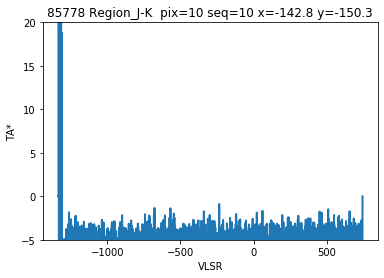

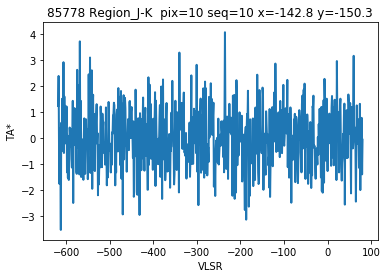

In [4]:
# For fun, here is a trial run with one processed spectrum 
ipix  = 10      # SEQUOIA PIXEL
ispec = 10  # otf spectrum in sequence (IRC_79957 8069)
# print x,y values
print('x= ',S.roach[ipix].xmap[S.roach[ipix].ons][ispec],'  y= ',S.roach[ipix].ymap[S.roach[ipix].ons][ispec])

# create a LineData object for line reduction
ll = LineData(I,bank,S.nchan,S.bandwidth,S.roach[ipix].reduced_spectra[ispec])
pl.plot(ll.xarray,ll.yarray)
pl.xlabel(ll.xname)
pl.ylabel('TA*')
pl.title('%d %s  pix=%d seq=%d x=%6.1f y=%6.1f'%(S.obsnum,S.source,ipix,ispec,S.roach[ipix].xmap[S.roach[ipix].ons][ispec],S.roach[ipix].ymap[S.roach[ipix].ons][ispec]))
pl.ylim([-5,20])

# select a slice from the spectrum and load into a Line object for processing
# limits are specified by velocity 
lll = ll.vslice(slice_list[0],slice_list[1])
# find channel numbers for baseline region
bblist,nblist = lll.xlist(baseline_list)
# remove the baseline
lll.baseline(bblist,nblist,baseline_order=1)
pl.figure()
pl.plot(lll.xarray,lll.yarray)
pl.xlabel(lll.xname)
pl.ylabel('TA*')
pl.title('%d %s  pix=%d seq=%d x=%6.1f y=%6.1f'%(S.obsnum,S.source,ipix,ispec,S.roach[ipix].xmap[S.roach[ipix].ons][ispec],S.roach[ipix].ymap[S.roach[ipix].ons][ispec]))

# CREATING A SPECFILE

### Set up Reduction Process

This step exists to (1) figure out the dimensions of the data array to be written to the SpecFile in NetCDF format; and (2) prepare header information for the spectral line data to be recorded.

The function `count_otf_spectra` just counts the total number of spectra to be processed.  This value is used to set the one of the dimensions of the NetCDF data written in the SpecFile. 

The next set of steps figures out the number of channels to be written for each spectrum, assuming that we limit the data to a slice of channels defined by the `vslice` method.  This step results in an instance of a Line object, `L`, thaht contains all the useful header variables needed for further spectroscopic analysis.


In [5]:
# count the total number of spectra that will be processed and written to file
total_spectra = count_otf_spectra(S,list_of_pixels)

# make a dummy spectrum to count the channels after processing steps
LD = LineData(I,bank,S.nchan,S.bandwidth,np.zeros(S.nchan))
L = LD.vslice(slice_list[0],slice_list[1])
nchan_to_save = L.nchan

0 14334 14334
1 14334 28668
2 14334 43002
3 14334 57336
4 14332 71668
5 14332 86000
6 14332 100332
7 14332 114664
8 14334 128998
9 14334 143332
10 14334 157666
11 14334 172000
12 14333 186333
13 14333 200666
14 14333 214999
15 14333 229332
Total Number of Spectra = 229332


### Writing the netCDF file

The SpecFile is a NetCDF file.  The script in the next code cell processes each of the spectra in the OTF map and writes it into the file.  SpecFiles are then used at the next step to actually grid the data into a data cube.

The beginning of the script sets up the NetCDF file for writing by defining and writing all the header variables.  

For a single file, all the spectral information is the same, so we have a class that uses the scan data header to write a set of NetCDF header variables.  This class has a method which, given a Line object, will write the header data to the netcdf file. 

Then, in the main for loop, we process each pixel in turn considering all spectra for that pixel.  Currently, the map coordinates are linked to the map mode used when the data were collected.  However, this need not be the case.  We could make maps in RA-Dec even if the data were obtained in Az-El.

For each spectrum, we process the data by fitting a baseline.  It is useful to limit the size of the SpecFile that will be written by limiting the number of channels to a region around the line of interest.  We do this by creating `L`, a LineData object with a single spectrum.  Then, we use the LineData method `vslice` to create a Line object, `LL`, which is a slice of the full array of spectral data covering the region given by `slice_list`.  `L` then contains the extracted data and the Line methods are used for computing the baseline.  Finally, the baselined data are written to the SpecFile.  Note that we followed the same steps to define the data to be written that were followed when we set up `nchan_to_save` in the previous code cell.

Eventually, this script will be written as a function with options to hide all the NetCDF stuff and make it easier to use.

In [6]:
# write the netCDF file

# open Dataset.  If the file exists, we stop here!
nc = netCDF4.Dataset(netcdf_filename, 'w', format='NETCDF4')
# dimension of number of spectra is from total number count
nc_dimension_nspec = nc.createDimension('nspec',total_spectra)
# dimension of nymber of channels in spectrum is from trial reduction step
nc_dimension_nchan = nc.createDimension('nchan',nchan_to_save)
# just doing 20 characters in string
nc_dimension_nlabel = nc.createDimension('nlabel',20)

# the Observation Header
nc_obsnum = nc.createVariable('Header.Obs.ObsNum','i4')
nc.variables['Header.Obs.ObsNum'][0] = S.obsnum

nc_source = nc.createVariable('Header.Obs.SourceName','c',('nlabel',))
if len(S.source) > 19:
    nc_source[0:19] = S.source[0:19]
else:
    nc_source[0:len(S.source)] = S.source[0:len(S.source)]

nc_x_position = nc.createVariable('Header.Obs.XPosition','f4')
nc_y_position = nc.createVariable('Header.Obs.YPosition','f4')
if S.map_coord == 1:
    nc.variables['Header.Obs.XPosition'][0] = S.ifproc.source_RA/np.pi*180.0
    nc.variables['Header.Obs.YPosition'][0] = S.ifproc.source_Dec/np.pi*180.0
else:
    nc.variables['Header.Obs.XPosition'][0] = 0.0
    nc.variables['Header.Obs.YPosition'][0] = 0.0


# using line header information derived from spec bank
ncl = NetCDFLineHeader(nc)
ncl.write_line_header_variables(L) # write using the result of trial run 
          
nc_pix = nc.createVariable('Data.Pixel','i4',('nspec',))
nc_seq = nc.createVariable('Data.Sequence','i4',('nspec',))
nc_x = nc.createVariable('Data.XPos','f4',('nspec',))
nc_x.units = 'arcsec'
nc_y = nc.createVariable('Data.YPos','f4',('nspec',))
nc_y.units = 'arcsec'
nc_rms = nc.createVariable('Data.RMS','f4',('nspec',))
nc_rms.units = 'K'
nc_data = nc.createVariable('Data.Spectra','f4',('nspec','nchan'))
nc_data.units = 'K'

count = 0
for ipix in list_of_pixels:
    i = S.find_pixel_index(ipix)
    n_spectra = len(S.roach[i].xmap[S.roach[i].ons])
    x_spectra = S.roach[i].xmap[S.roach[i].ons] # x coordinate
    y_spectra = S.roach[i].ymap[S.roach[i].ons] # y coordinate
    if I.map_coord == 0:
        gx,gy = theGrid.azel(S.elev/180.*np.pi,I.tracking_beam)
    else:
        parang = np.mean(S.roach[i].pmap[S.roach[i].ons]) # average parang
        gx,gy = theGrid.radec(S.elev/180.*np.pi,parang,I.tracking_beam)

    for j in range(n_spectra):
        # process each spectrum
        L = LineData(I,bank,S.nchan,S.bandwidth,S.roach[i].reduced_spectra[j])
        LL = L.vslice(slice_list[0],slice_list[1])
        bbase,nbase = LL.xlist(baseline_list)
        LL.baseline(bbase,nbase,baseline_order=baseline_order)
        
        # write the reduced line into the NetCDF file
        nc_data[count,:] = LL.yarray
        nc_rms[count] = LL.rms
        nc_pix[count] = ipix
        nc_seq[count] = j
        nc_x[count] = x_spectra[j]-gx[ipix]
        nc_y[count] = y_spectra[j]-gy[ipix]
        count = count + 1


nc.close()        
print('netCDF Done')




netCDF Done


### Simple Example of Reading back the SpecFile

The following code cell provides a simple illustration of reading some data back from the SpecFile we have just written.

ObsNum = 85778
Source = Region_J-K
number of channels= 689
x axis name= VLSR
x extremes = -215.710373 197.543594
y extremes = -185.765594 222.951889


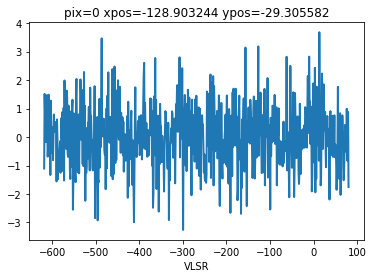

In [7]:
# read back the netcdf file as a check
nc = netCDF4.Dataset(netcdf_filename, 'r', format='NETCDF4')
print('ObsNum = %d'%(nc.variables['Header.Obs.ObsNum'][0]))
print('Source = %s'%(netCDF4.chartostring(nc.variables['Header.Obs.SourceName'][:])))

ncl = NetCDFLineHeader(nc)
ncl.read_line_header_variables(L)
print('number of channels= %d'%(L.nchan))
print('x axis name= %s'%(L.xname))

xpos = nc.variables['Data.XPos']
ypos = nc.variables['Data.YPos']
pix = nc.variables['Data.Pixel']
print('x extremes = %f %f'%(np.min(xpos),np.max(xpos)))
print('y extremes = %f %f'%(np.min(ypos),np.max(ypos)))

# plot a spectrum for one dump
ipos = 2636
pl.plot(nc.variables['Header.SpectrumAxis.CAXIS'],nc.variables['Data.Spectra'][ipos][:])
pl.title('pix=%d xpos=%f ypos=%f'%(pix[ipos],xpos[ipos],ypos[ipos]))
pl.xlabel(L.xname)
nc.close()

# VIEWING THE SPECFILE

The following code cells are being turned into a new class to provide methods for reading and displaying SpecFiles.

In the first code cell, below, we just read the data.

In [8]:
nc = netCDF4.Dataset(netcdf_filename, 'r', format='NETCDF4')
obsnum = nc.variables['Header.Obs.ObsNum'][0]
source_name = netCDF4.chartostring(nc.variables['Header.Obs.SourceName'][:])

x_position =  nc.variables['Header.Obs.XPosition'][0]
y_position =  nc.variables['Header.Obs.YPosition'][0]

nchan = nc.variables['Header.Line.NChannels'][0]
chan = nc.variables['Header.Line.ChannelNumber'][:]
cdelt = nc.variables['Header.SpectrumAxis.CDELT'][0]
crpix = nc.variables['Header.SpectrumAxis.CRPIX'][0]
crval = nc.variables['Header.SpectrumAxis.CRVAL'][0]
ctype = netCDF4.chartostring(nc.variables['Header.SpectrumAxis.CTYPE'][:])
caxis = nc.variables['Header.SpectrumAxis.CAXIS'][:]

print('number of channels= %d'%(nchan))

pixel = nc.variables['Data.Pixel'][:]
xpos = nc.variables['Data.XPos'][:]
ypos = nc.variables['Data.YPos'][:]
rms = nc.variables['Data.RMS'][:]
data = nc.variables['Data.Spectra'][:]

print('shape of OTF data %d %d'%(np.shape(data)))
nc.close()

number of channels= 689
shape of OTF data 229332 689


### SpecFile Plotting Example 1

These are some example plots of the data in the SpecFile.  

The first is a *waterfall* plot of all the spectra.  In this case, it is easy to see the line from the source in each pixel of the array (as vertical yellow stripes).  However, we can also see other features where individual spectra have poor baselines.

The second example shows a simple graph of the baseline RMS for each spectrum in each pixel.  It is clear that some of the spectra have much poorer baselines.  These are candidates for elimination when we construct our data cube. 

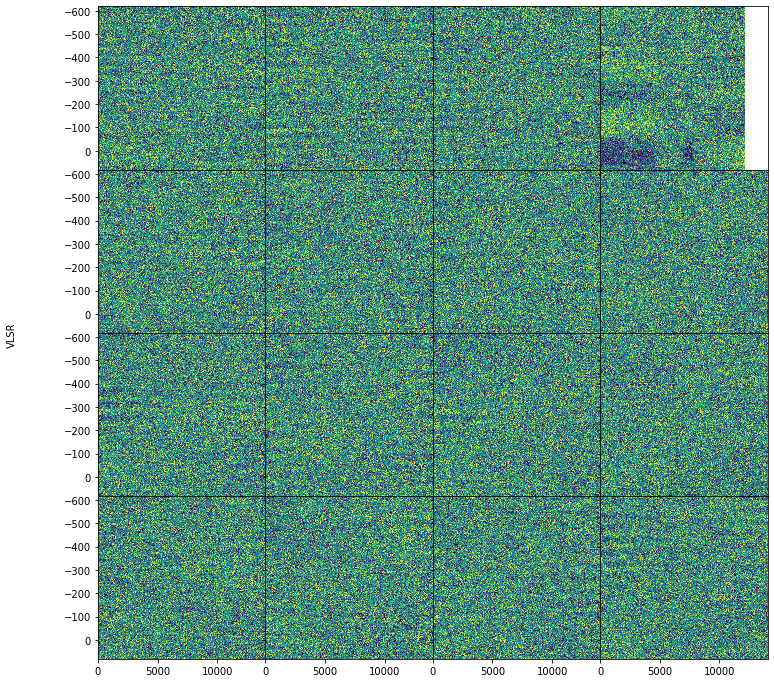

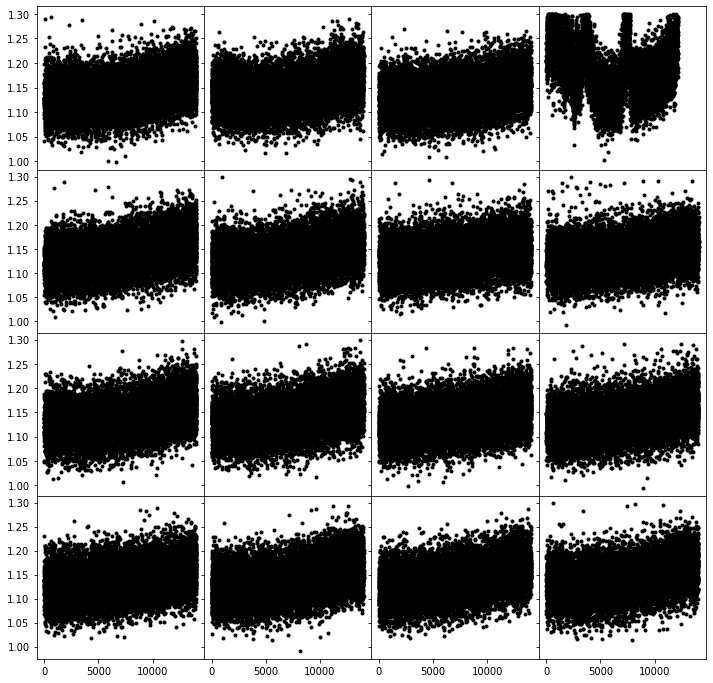

In [9]:
fig1, ax1 = pl.subplots(4, 4, sharex='col', sharey='row',gridspec_kw={'hspace': 0, 'wspace': 0},figsize=(12,12))
fig2, ax2 = pl.subplots(4, 4, sharex='col', sharey='row',gridspec_kw={'hspace': 0, 'wspace': 0},figsize=(12,12))
fig1.text(0.02, 0.5, ctype, va='center', rotation='vertical')
j=0
k=0
for i in range(0,16):
    the_pixel = i
    rms_cut = 1.3
    pindex = np.where(pixel==the_pixel)[0]
    rindex = np.where(rms[pindex]<rms_cut)[0]
    #print()'Total Scans for pixel %d = %d   Good Scans = %d'%(the_pixel,len(pindex),len(rindex)))
    ax1[j,k].imshow(data[pindex[rindex]].transpose(),origin='lower',extent=[0.,float(len(rindex)),caxis[0],caxis[-1]],clim=[-2,2],aspect='auto')
    ax2[j,k].plot(rms[pindex[rindex]],'k.')
    if(k == 3):
        k=0
        j=j+1
    else:
        k=k+1

### SpecFile Plotting Example 2

Here are two other examples.  Ths first is a histrogram of the RMS values in the spectra for each pixel.  Note that there is often a second peak, corresponding to "bad" spectra.  We can use histograms like this to select rms values to be excluded when the data cube is prepared.

The second plot shows the mean of all the spectra.  For this map, the line is apparent.  We also see the effect of poor baselines on an average of all spectra.

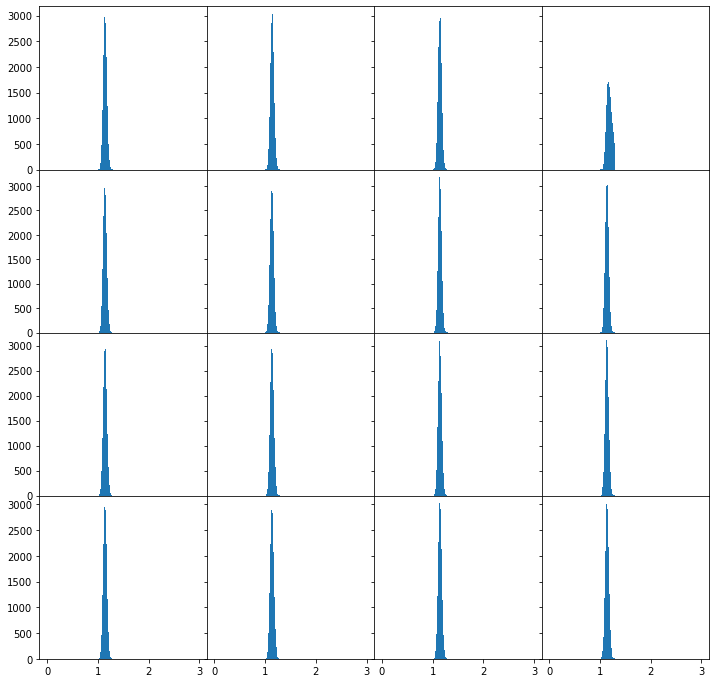

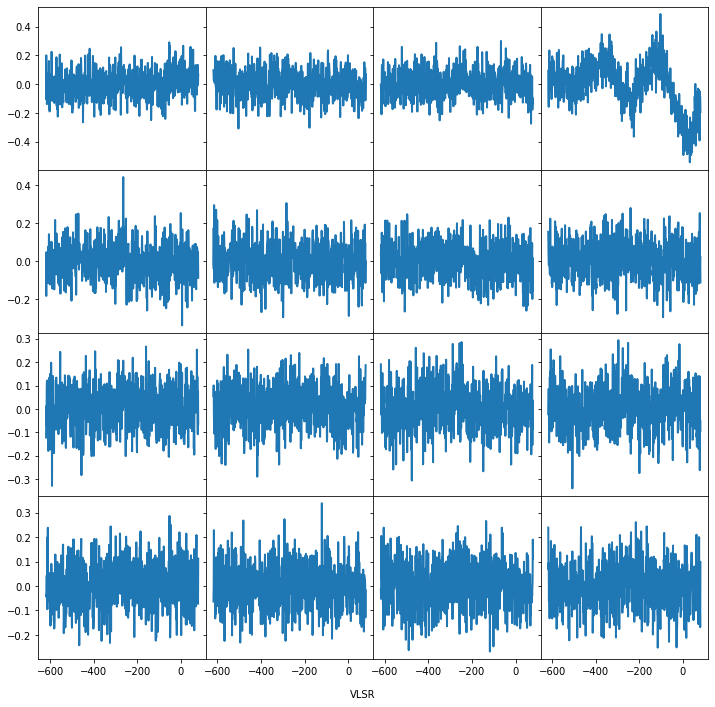

In [10]:
fig3, ax3 = pl.subplots(4, 4, sharex='col', sharey='row',gridspec_kw={'hspace': 0, 'wspace': 0},figsize=(12,12))
fig4, ax4 = pl.subplots(4, 4, sharex='col', sharey='row',gridspec_kw={'hspace': 0, 'wspace': 0},figsize=(12,12))
fig4.text(0.5, 0.08, ctype, ha='center')
j=0
k=0
for i in range(0,16):
    the_pixel = i
    pindex = np.where(pixel==the_pixel)[0]
    rindex = np.where(rms[pindex]<rms_cut)[0]

    ax3[j,k].hist(rms[pindex[rindex]],bins=np.arange(0.,3.02,.02))
    ax4[j,k].plot(caxis,np.mean(data[pindex[rindex]],axis=0))
    if(k == 3):
        k=0
        j=j+1
    else:
        k=k+1

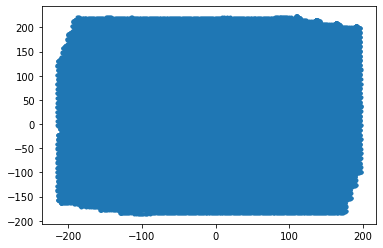

In [11]:
pl.plot(xpos,ypos,'.')

# OTF GRIDDING

The OTF gridding routine takes the spectral line data in the SpecFile and convolves it into a regular grid.

The OTF routine has been written in C.  The executable program is run as a subprocess call.   The program has a number of switches which allow parameters, such as file names, to be input to the program.

The set of command line arguments is:

* `-h` - help list of all commands (no argument) ... not necessarily up to date.
* `-i` - input file name
* `-o` - output file name
* `-l` - resolution_size; the actual $\lambda/D$ (arcsec)
* `-c` - cell_size; nominally $\lambda/(2D)$ (arcsec)
* `-z` - rms cutoff value for inclusion in the cube (K)
* `-f` - specifies convolution filter (0=PILL BOX; 1=JINC; 2=GAUSSIAN)
* `-x` - x extent of the map (arcsec)
* `-y` - y extent of the map (arcsec)
* `-r` - maximum extent of convolution function in units of $\lambda/D$
* `-0` - the jinc "a" parameter
* `-1` - the jinc "b" parameter (also gaussian half power)
* `-2` - the jinc "c" parameter

In [12]:
with open('out.txt','w+') as outputfile:
    with open('err.txt','w+') as errorfile:
        exit_code=subprocess.call([ProgramPath,
                             '-i',netcdf_filename,
                             '-o',FitsFileName,
                             '-x',xextent,
                             '-y',yextent,
                             '-z',rmscutoff],
                            stdout=outputfile,
                            stderr=errorfile)
        # reset stdout file to read from it
        outputfile.seek(0)
        # save output (if any) in variable
        standard_output=outputfile.read()
        print('STDOUT ****************************')
        print(standard_output)

        # reset stderr file to read from it
        errorfile.seek(0) 
        # save errors (if any) in variable
        standard_error = errorfile.read()
        print('STDERR ****************************')
        print(standard_error)
print('Exit Code: %d'%(exit_code))



STDOUT ****************************
about to open file ./M31_Region_J-K.nc
file ./M31_Region_J-K.nc opened
Dimensions complete 229332 689
Header.Obs complete
Header.SpectrumAxis.CRVAL
Header.SpectrumAxis.CRPIX
Header.SpectrumAxis.CDELT
Header.SpectrumAxis.CTYPE
Header.SpectrumAxis.XAxis
Data.Spectra
Data.Spectra completed
Data.XPos
Data.YPos
Data.Pixel
Data.Sequence
Data.RMS
file: ./M31_Region_J-K.nc nspec= 229332 nchan= 689
allocated theData
n_cell= 7
r (as)   c
 0.00   1.0000
 0.16   0.9994
 0.33   0.9975
 0.49   0.9945
 0.66   0.9902
 0.82   0.9847
 0.99   0.9780
 1.15   0.9701
 1.32   0.9611
 1.48   0.9509
 1.65   0.9396
 1.81   0.9273
 1.98   0.9139
 2.14   0.8995
 2.31   0.8842
 2.47   0.8679
 2.64   0.8507
 2.80   0.8327
 2.96   0.8139
 3.13   0.7943
 3.29   0.7741
 3.46   0.7531
 3.62   0.7316
 3.79   0.7096
 3.95   0.6870
 4.12   0.6640
 4.28   0.6407
 4.45   0.6170
 4.61   0.5930
 4.78   0.5689
 4.94   0.5445
 5.11   0.5201
 5.27   0.4956
 5.44   0.4712
 5.60   0.4467
 5.76  

# VIEWING THE DATA CUBE

With the FITS data cube written, we may now wish to view the result.  Fortunately, *astropy* provides useful routines to read FITS data cubes and display them in an appropriate World Coordinate System.  The CubeReader class provides a simple interface to these routines as well as some methods to manipulate the cube.

### Read the Cube

The first code cell illustrates simply reading the cube and showing the header.

The cube axes are labeled 'x', 'y', and 'v', and methods use these labels to extract data from the cube.

In [13]:
from cube_reader import *
# Open FITS file using CubeReader 
Cube = CubeReader(FitsFileName,1,2,3)
# print the header
Cube.PrintHeader()
# print some information about the cube
Cube.GetInfo()

SIMPLE  =                    T / file does conform to FITS standard             
BITPIX  =                  -32 / number of bits per data pixel                  
NAXIS   =                    3 / number of data axes                            
NAXIS1  =                   73 / length of data axis 1                          
NAXIS2  =                   73 / length of data axis 2                          
NAXIS3  =                  689 / length of data axis 3                          
EXTEND  =                    T / FITS dataset may contain extensions            
COMMENT   FITS (Flexible Image Transport System) format is defined in 'Astronomy
COMMENT   and Astrophysics', volume 376, page 359; bibcode: 2001A&A...376..359H 
TELESCOP= 'LMT     '           /                                                
OBJECT  = 'Region_J-K'         /                                                
OBSNUM  =                85778 /                                                
BUNIT   = 'K       '        

### View a Map from a 2D slice of data from the cube

The next example shows the 2D map of a single spectral channel in the cube.  Note that this is a slice of the "v" axis at channel `v_val`.

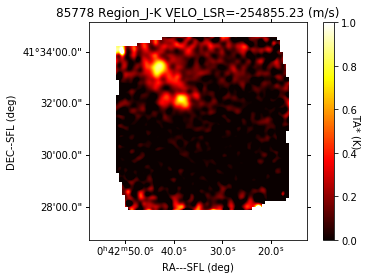

In [14]:

Cube.Slice('v',v_val,colormap=pl.cm.hot,maximum=Cmax,xbegin=xb,xend=xe,ybegin=yb,yend=ye)


### View Line of Data through the Cube

These examples show a single line of data extracted from the cube in each of the three possible directions.

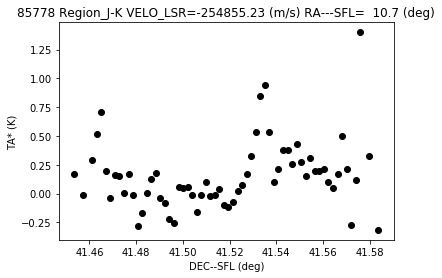

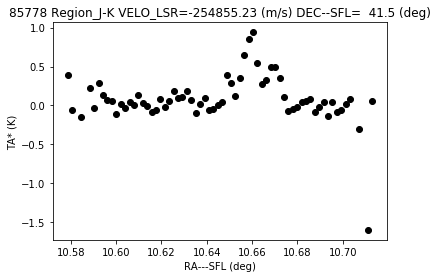

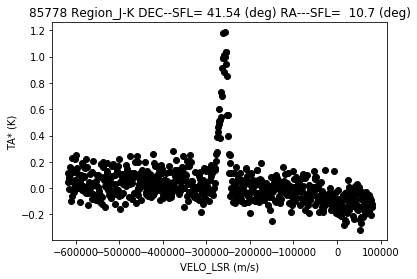

In [15]:
# spectral channel v_val plotted for all declinations at ra given by x_val
Cube.ShowSpectrum('x',x_val,'v',v_val)

# spectral channel v_val plotted for all ra's at declination given by y_val
Cube.ShowSpectrum('y',y_val,'v',v_val)

# all spectral channels plotted for a single pixel: ra given by x_val; dec given by y_val 
Cube.ShowSpectrum('x',x_val,'y',y_val) 


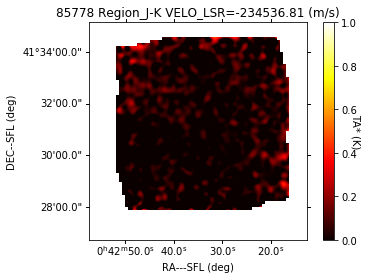

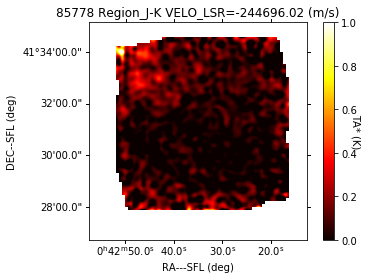

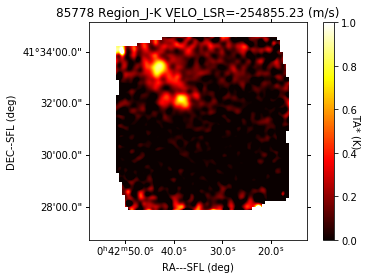

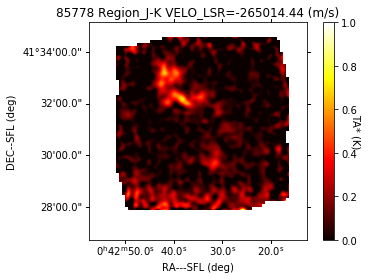

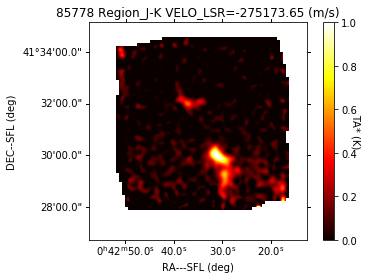

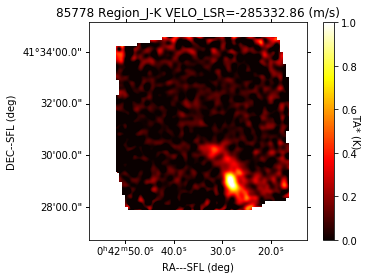

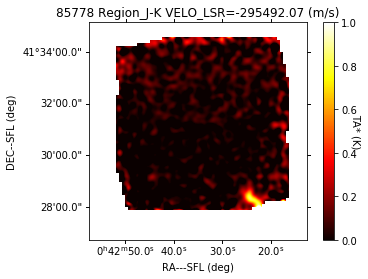

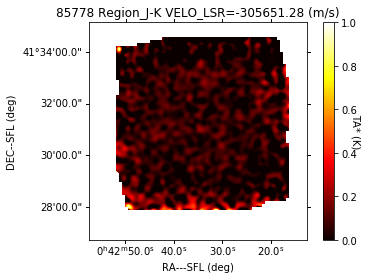

In [16]:
# Cube_Reader Parameters
Cmax = 1
xb,xe=0,72
yb,ye=0,72

v_val=310
Cube.Slice('v',v_val,colormap=pl.cm.hot,maximum=Cmax,xbegin=xb,xend=xe,ybegin=yb,yend=ye)

v_val=320
Cube.Slice('v',v_val,colormap=pl.cm.hot,maximum=Cmax,xbegin=xb,xend=xe,ybegin=yb,yend=ye)

v_val=330
Cube.Slice('v',v_val,colormap=pl.cm.hot,maximum=Cmax,xbegin=xb,xend=xe,ybegin=yb,yend=ye)

v_val=340
Cube.Slice('v',v_val,colormap=pl.cm.hot,maximum=Cmax,xbegin=xb,xend=xe,ybegin=yb,yend=ye)

v_val=350
Cube.Slice('v',v_val,colormap=pl.cm.hot,maximum=Cmax,xbegin=xb,xend=xe,ybegin=yb,yend=ye)


v_val=360
Cube.Slice('v',v_val,colormap=pl.cm.hot,maximum=Cmax,xbegin=xb,xend=xe,ybegin=yb,yend=ye)

v_val=370
Cube.Slice('v',v_val,colormap=pl.cm.hot,maximum=Cmax,xbegin=xb,xend=xe,ybegin=yb,yend=ye)

v_val=380
Cube.Slice('v',v_val,colormap=pl.cm.hot,maximum=Cmax,xbegin=xb,xend=xe,ybegin=yb,yend=ye)






